# Multimedia Forensics Exercise 2
Tientso Ning

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
%matplotlib inline

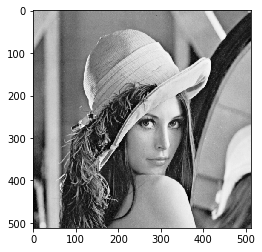

In [2]:
#read original image
img = cv2.imread("./Lab2_JPEG/lena_512.bmp")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #COLOR_BGR2YCR_CB
plt.imshow(img, cmap="Greys_r")

In [3]:
#zigzag function
def zigzag (a):
    return np.concatenate([np.diagonal(a[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-a.shape[0], a.shape[0])])

#zigzag test
print(zigzag(np.array([[1,2,3],[4,5,6],[7,8,9]])))

[1 4 2 3 5 7 8 6 9]


In [4]:
#Quality Factor, we can tweek these
QF1 = 50
QF2 = 75

Q50 = np.array([[16,11,10,16,24,40,51,61],[12,12,14,19,26,58,60,55],[14,13,16,24,40,57,69,56],[14,17,22,29,51,87,80,62],[18,22,37,56,68,109,103,77],[24,35,55,64,81,104,113,92],[49,64,78,87,103,121,120,101],[72,92,95,98,112,100,103,99]], order='F')
print(Q50)

[[ 16  11  10  16  24  40  51  61]
 [ 12  12  14  19  26  58  60  55]
 [ 14  13  16  24  40  57  69  56]
 [ 14  17  22  29  51  87  80  62]
 [ 18  22  37  56  68 109 103  77]
 [ 24  35  55  64  81 104 113  92]
 [ 49  64  78  87 103 121 120 101]
 [ 72  92  95  98 112 100 103  99]]


In [5]:
#Quality Matrix for QF1
if QF1 > 50:
    QM1 = np.around(Q50*(np.ones(Q50.shape)*((100-QF1)/50)))
    QM1.astype(int)

elif QF1 < 50:
    QM1 = np.around(Q50*(np.ones(Q50.shape)*(50/QF1)))
    QM1.astype(int)

elif QF1 == 50:
    QM1 = Q50
    
else:
    print("error")

QM1.astype(float)

array([[ 16.,  11.,  10.,  16.,  24.,  40.,  51.,  61.],
       [ 12.,  12.,  14.,  19.,  26.,  58.,  60.,  55.],
       [ 14.,  13.,  16.,  24.,  40.,  57.,  69.,  56.],
       [ 14.,  17.,  22.,  29.,  51.,  87.,  80.,  62.],
       [ 18.,  22.,  37.,  56.,  68., 109., 103.,  77.],
       [ 24.,  35.,  55.,  64.,  81., 104., 113.,  92.],
       [ 49.,  64.,  78.,  87., 103., 121., 120., 101.],
       [ 72.,  92.,  95.,  98., 112., 100., 103.,  99.]])

In [6]:
#Quality Matrix for QF2
if QF2 > 50:
    QM2 = np.around(Q50*(np.ones(Q50.shape)*((100-QF2)/50)))
    QM2.astype(int)

elif QF2 < 50:
    QM2 = np.around(Q50*(np.ones(Q50.shape)*(50/QF2)))
    QM2.astype(int)

elif QF2 == 50:
    QM2 = Q50
    
else:
    print("error")

QM2.astype(float)

array([[ 8.,  6.,  5.,  8., 12., 20., 26., 30.],
       [ 6.,  6.,  7., 10., 13., 29., 30., 28.],
       [ 7.,  6.,  8., 12., 20., 28., 34., 28.],
       [ 7.,  8., 11., 14., 26., 44., 40., 31.],
       [ 9., 11., 18., 28., 34., 54., 52., 38.],
       [12., 18., 28., 32., 40., 52., 56., 46.],
       [24., 32., 39., 44., 52., 60., 60., 50.],
       [36., 46., 48., 49., 56., 50., 52., 50.]])

In [7]:
#DCT domain
dct_domain = np.zeros(img.shape) #should just be same shape
dct_quantized = np.zeros(img.shape)
dct_dequantized = np.zeros(img.shape)
dct_restored = np.zeros(img.shape)

dct_domain2 = np.zeros(img.shape)
dct_quantized2 = np.zeros(img.shape)

#updates
dct_quantized_coeff = np.zeros((64,(img.shape[0]//8)*(img.shape[1]//8)))
dct_quantized2_coeff = np.zeros((64,(img.shape[0]//8)*(img.shape[1]//8)))

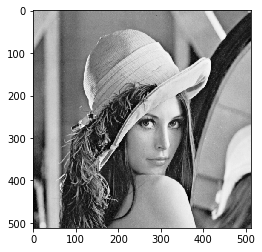

In [8]:
#Subtract each img value by 128
img2 = img - (128*np.ones(img.shape))
plt.imshow(img2, cmap="Greys_r")

In [9]:
#JPEG Encoding

k = 0
for i in range(0, img2.shape[0], 8): #row 8x8
    
    for j in range(0, img.shape[1], 8):
        
        block = img2[i:i+8,j:j+8] #set the block
        win1 = dct(block, norm='ortho') #dct(dct(block.T, norm='ortho').T, norm="ortho")
        dct_domain[i:i+8,j:j+8] = win1
        
        win2 = np.around(win1/QM1)
        dct_quantized[i:i+8,j:j+8] = win2
        dct_quantized_coeff[:,k] = zigzag(win2)
        k += 1

In [10]:
#JPEG Decoding

for i in range(0, img2.shape[0], 8):
    
    for j in range(0, img2.shape[1], 8):
        
        win2 = dct_quantized[i:i+8, j:j+8]
        win3 = win2*QM1 #dequantization of DCT coeff
        dct_dequantized[i:i+8, j:j+8] = win3       
        win4 = idct(win3, norm='ortho') #dct(dct(win3.T, norm='ortho').T, norm="ortho")
        dct_restored[i:i+8, j:j+8] = win4
        

(512, 512)


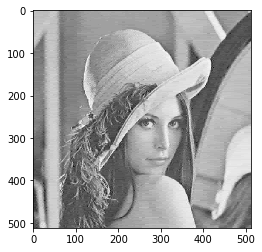

In [11]:
#img reconstruction?
img2_recon = dct_restored
plt.imshow(img2_recon+128, cmap="Greys_r") #sanity check on recon image
print(dct_restored.shape)

In [12]:
#JPEG Encoding 2 (double compression)

k=0
for i in range(0, img.shape[0], 8): #row 8x8
    
    for j in range(0, img.shape[1], 8):
        
        block = img2_recon[i:i+8,j:j+8] #set the block
        win5 = dct(block, norm='ortho')
        dct_domain2[i:i+8,j:j+8] = win5
        
        win6 = np.around(win5/QM2)
        dct_quantized2[i:i+8,j:j+8] = win2
        dct_quantized2_coeff[:,k] = zigzag(win6)
        k += 1

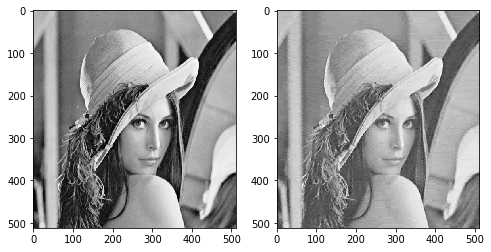

In [13]:
#both image and recon image side by side
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(img, cmap="Greys_r", aspect="auto")
ax[1].imshow(img2_recon+128, cmap="Greys_r", aspect="auto")

<Figure size 864x1152 with 0 Axes>

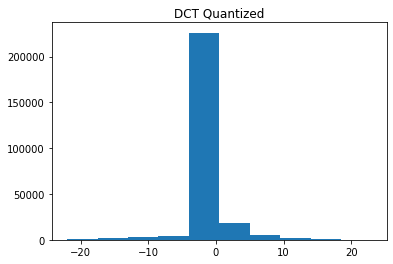

<Figure size 864x1152 with 0 Axes>

In [14]:
#histograms
plt.hist(dct_quantized.flatten())
plt.title("DCT Quantized")
plt.figure(figsize=(12,16))

<Figure size 864x1152 with 0 Axes>

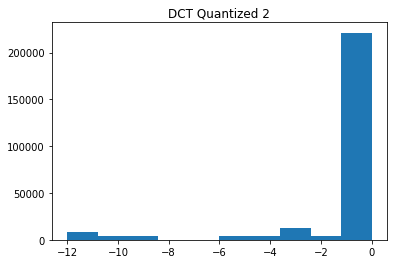

<Figure size 864x1152 with 0 Axes>

In [15]:
#histograms
plt.hist(dct_quantized2.flatten())
plt.title("DCT Quantized 2")
plt.figure(figsize=(12,16))

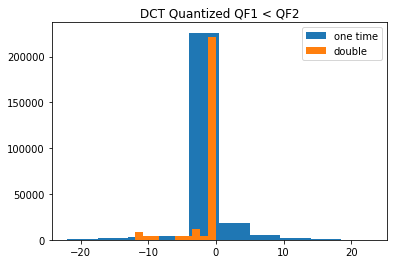

In [16]:
plt.hist(dct_quantized.flatten(), label="one time")
plt.hist(dct_quantized2.flatten(), label="double")
plt.title("DCT Quantized QF1 < QF2")
plt.legend()
plt.show()

We expect to see some results like we saw in class, with some bins missing and overlaps, we may see something, but it is harder to notice. The quality is not good

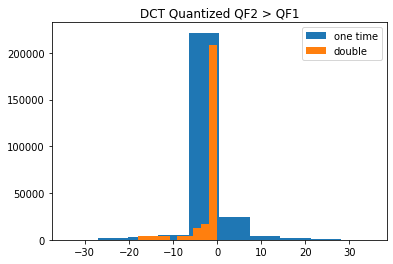

In [17]:
#show different Quality Factors histogram
QF1 = 66
QF2 = 80

Q50 = np.array([[16,11,10,16,24,40,51,61],[12,12,14,19,26,58,60,55],[14,13,16,24,40,57,69,56],[14,17,22,29,51,87,80,62],[18,22,37,56,68,109,103,77],[24,35,55,64,81,104,113,92],[49,64,78,87,103,121,120,101],[72,92,95,98,112,100,103,99]], order='F')

#Quality Matrix for QF1
if QF1 > 50:
    QM1 = np.around(Q50*(np.ones(Q50.shape)*((100-QF1)/50)))
    QM1.astype(int)

elif QF1 < 50:
    QM1 = np.around(Q50*(np.ones(Q50.shape)*(50/QF1)))
    QM1.astype(int)

elif QF1 == 50:
    QM1 = Q50
    
else:
    print("error")

QM1.astype(float)

#Quality Matrix for QF2
if QF2 > 50:
    QM2 = np.around(Q50*(np.ones(Q50.shape)*((100-QF2)/50)))
    QM2.astype(int)

elif QF2 < 50:
    QM2 = np.around(Q50*(np.ones(Q50.shape)*(50/QF2)))
    QM2.astype(int)

elif QF2 == 50:
    QM2 = Q50
    
else:
    print("error")

QM2.astype(float)

#DCT domain
dct_domain = np.zeros(img.shape) #should just be same shape
dct_quantized = np.zeros(img.shape)
dct_dequantized = np.zeros(img.shape)
dct_restored = np.zeros(img.shape)

dct_domain2 = np.zeros(img.shape)
dct_quantized2 = np.zeros(img.shape)

#JPEG Encoding

for i in range(0, img2.shape[0], 8): #row 8x8
    
    for j in range(0, img.shape[1], 8):
        
        block = img2[i:i+8,j:j+8] #set the block
        win1 = dct(block, norm='ortho') #dct(dct(block.T, norm='ortho').T, norm="ortho")
        dct_domain[i:i+8,j:j+8] = win1
        
        win2 = np.around(win1/QM1)
        dct_quantized[i:i+8,j:j+8] = win2

for i in range(0, img.shape[0], 8): #row 8x8
    
    for j in range(0, img.shape[1], 8):
        
        block = img2_recon[i:i+8,j:j+8] #set the block
        win5 = dct(block, norm='ortho')
        dct_domain2[i:i+8,j:j+8] = win5
        
        win6 = np.around(win5/QM2)
        dct_quantized2[i:i+8,j:j+8] = win2
        

plt.hist(dct_quantized.flatten(), label="one time")
plt.hist(dct_quantized2.flatten(), label="double")
plt.title("DCT Quantized QF2 > QF1")
plt.legend()
plt.show()

As we can see, the results are still not very good, as mentioned above

In [18]:
#pairwise analysis of DCT Coefficients

hist1 = []
hist2 = []

for i in range(0,10):
    min_dct = min(min(dct_quantized_coeff[i,:]), min(dct_quantized2_coeff[i,:]))
    max_dct = max(max(dct_quantized_coeff[i,:]), max(dct_quantized2_coeff[i,:]))
    
    x_bin = []
    for i in range(int(min_dct),int(max_dct)+1):
        x_bin.append(i)

Text(0.5, 1.0, '1st DCT Coefficient pairwise')

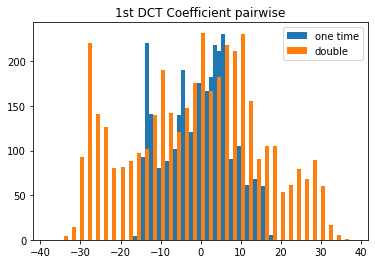

In [19]:
#DCT coefficient pairwise 
plt.hist(dct_quantized_coeff[0,:], bins=x_bin, label="one time")
plt.hist(dct_quantized2_coeff[0,:], bins=x_bin, label="double")
plt.legend()
plt.title("1st DCT Coefficient pairwise")

Text(0.5, 1.0, '2nd DCT Coefficient pairwise')

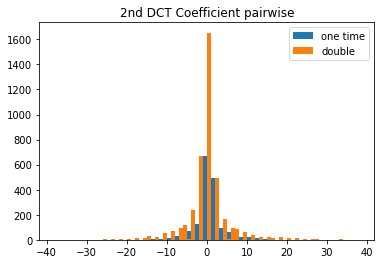

In [20]:
plt.hist(dct_quantized_coeff[1,:], bins=x_bin, label="one time")
plt.hist(dct_quantized2_coeff[1,:], bins=x_bin, label="double")
plt.legend()
plt.title("2nd DCT Coefficient pairwise")

Text(0.5, 1.0, '3rd DCT Coefficient pairwise')

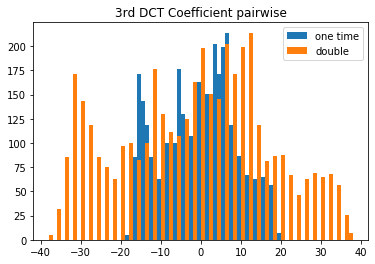

In [21]:
plt.hist(dct_quantized_coeff[3,:], bins=x_bin, label="one time")
plt.hist(dct_quantized2_coeff[3,:], bins=x_bin, label="double")
plt.legend()
plt.title("3rd DCT Coefficient pairwise")

Text(0.5, 1.0, '4th DCT Coefficient pairwise')

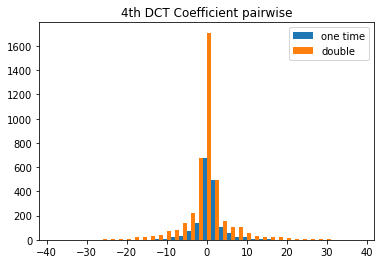

In [22]:
plt.hist(dct_quantized_coeff[4,:], bins=x_bin, label="one time")
plt.hist(dct_quantized2_coeff[4,:], bins=x_bin, label="double")
plt.legend()
plt.title("4th DCT Coefficient pairwise")

Text(0.5, 1.0, '5th DCT Coefficient pairwise')

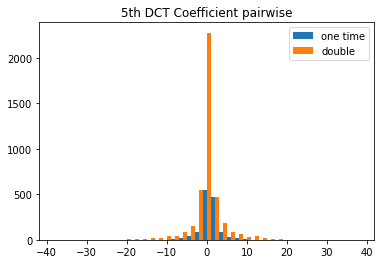

In [23]:
plt.hist(dct_quantized_coeff[5,:], bins=x_bin, label="one time")
plt.hist(dct_quantized2_coeff[5,:], bins=x_bin, label="double")
plt.legend()
plt.title("5th DCT Coefficient pairwise")

Text(0.5, 1.0, '6th DCT Coefficient pairwise')

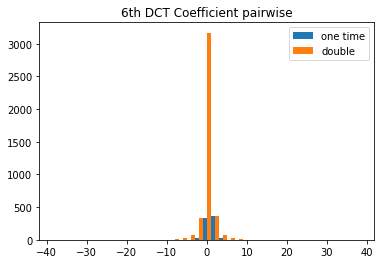

In [24]:
plt.hist(dct_quantized_coeff[6,:], bins=x_bin, label="one time")
plt.hist(dct_quantized2_coeff[6,:], bins=x_bin, label="double")
plt.legend()
plt.title("6th DCT Coefficient pairwise")

Here when we do the pairwise coefficients we can really see the difference, and notice the results where we expect to see the orange (double compressed) image show distinct empty bins.

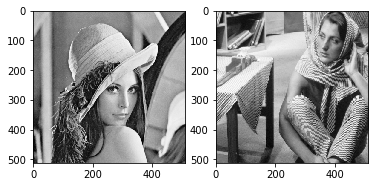

In [25]:
#step 3, prep compression of images
img1 = cv2.imread("./updates/lena_512.bmp",0)
img2 = cv2.imread("./updates/barbara512.bmp",0)
f,ax = plt.subplots(1,2)
ax[0].imshow(img1, cmap="Greys_r")
ax[1].imshow(img2, cmap="Greys_r")